### Load the dataset

In [1]:
from datasets import load_dataset, concatenate_datasets
from tqdm.notebook import tqdm
# Load the dataset
dataset = load_dataset("fancyzhx/amazon_polarity")

### Filter and inspect the dataset

In [2]:
import pandas as pd
df = dataset['train'].to_pandas()

df_positive = df[df['label'] == 1]
df_negative = df[df['label'] == 0]

df_filtered = pd.concat([df_positive, df_negative]).sample(frac=1, random_state=42)

### Construct hierarchically nested data splits

In [3]:
# Define nested training set sizes
nested_sizes = [100, 500, 1000, 2500, 5000]
nested_splits = {}

for size in nested_sizes:
    nested_splits[f"train_{size}"] = df_filtered.iloc[:size]

# Create a fixed test set (20% of full set)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_filtered, test_size=0.2, stratify=df_filtered['label'], random_state=42)

### Create weak labels for unlabeled texts

In [4]:
# Split 80% labeled (for nested splits), 20% unlabeled (for weak labelling)
labeled_df, unlabeled_df = train_test_split(train_data, test_size=0.2, stratify=train_data['label'], random_state=42)

# Remove labels from the unlabeled_df
unlabeled_df_weak = unlabeled_df.copy()
unlabeled_df_weak['label'] = None

### EDA

Full filtered dataset shape: (3600000, 3)
Labeled data shape: (2304000, 3)
Unlabeled data shape (for weak labeling): (576000, 3)


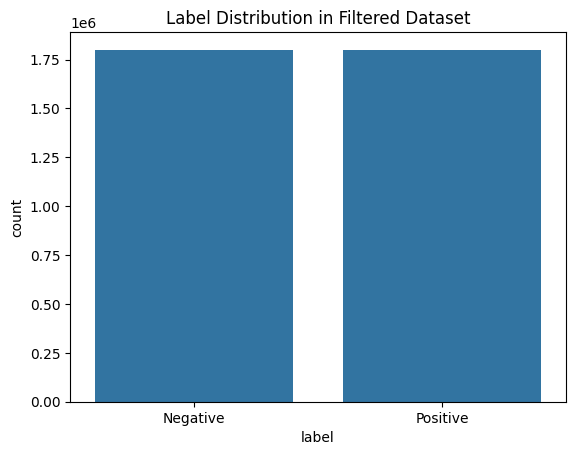

In [5]:
# Basic dataset info
print("Full filtered dataset shape:", df_filtered.shape)
print("Labeled data shape:", labeled_df.shape)
print("Unlabeled data shape (for weak labeling):", unlabeled_df_weak.shape)

# Label distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df_filtered, x="label")
plt.title("Label Distribution in Filtered Dataset")
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

### Nested split growth

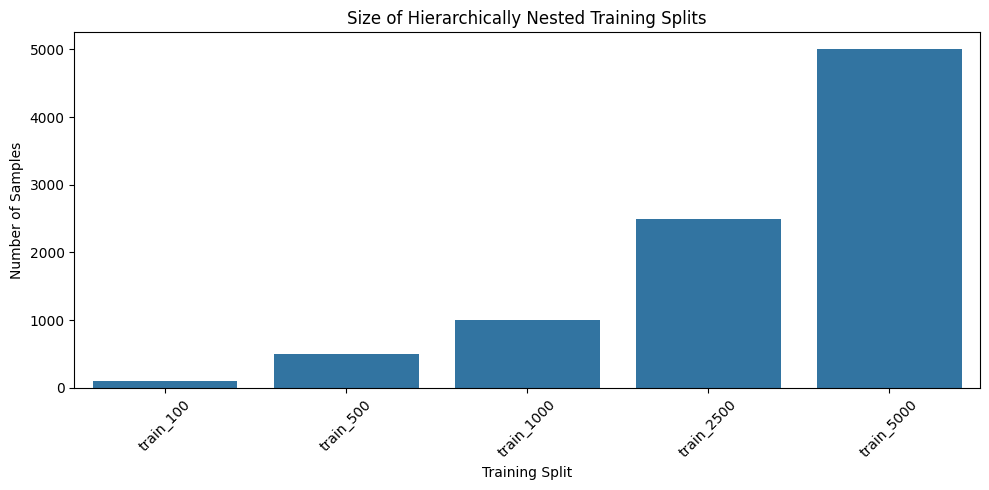

In [6]:
# Data for plotting nested split sizes
nested_split_sizes = [len(nested_splits[k]) for k in nested_splits]
split_names = list(nested_splits.keys())

plt.figure(figsize=(10, 5))
sns.barplot(x=split_names, y=nested_split_sizes)
plt.title("Size of Hierarchically Nested Training Splits")
plt.ylabel("Number of Samples")
plt.xlabel("Training Split")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Example sample

In [7]:
# Show random samples
df_filtered.sample(3)[['title', 'content', 'label']]

,title,content,label
1907635,Super cookware!!,My family got me the Cop-r-core set of All Cla...,1
1495983,It really is a MUST HAVE,If you bought the food processor which I am as...,1
2092179,Stigma,Excellent discussion of what stigma is and how...,1


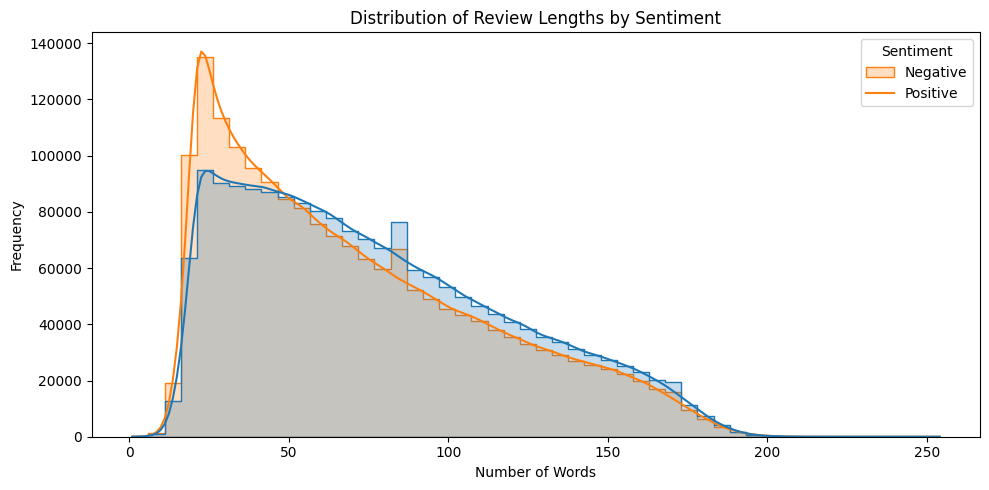

In [8]:
# Add review length column
df_filtered["review_length"] = df_filtered["content"].apply(lambda x: len(x.split()))

# Plot distribution by label
plt.figure(figsize=(10, 5))
sns.histplot(data=df_filtered, x="review_length", hue="label", bins=50, kde=True, element="step")
plt.title("Distribution of Review Lengths by Sentiment")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.tight_layout()
plt.show()

[nltk_data] Downloading package stopwords to /home/arian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


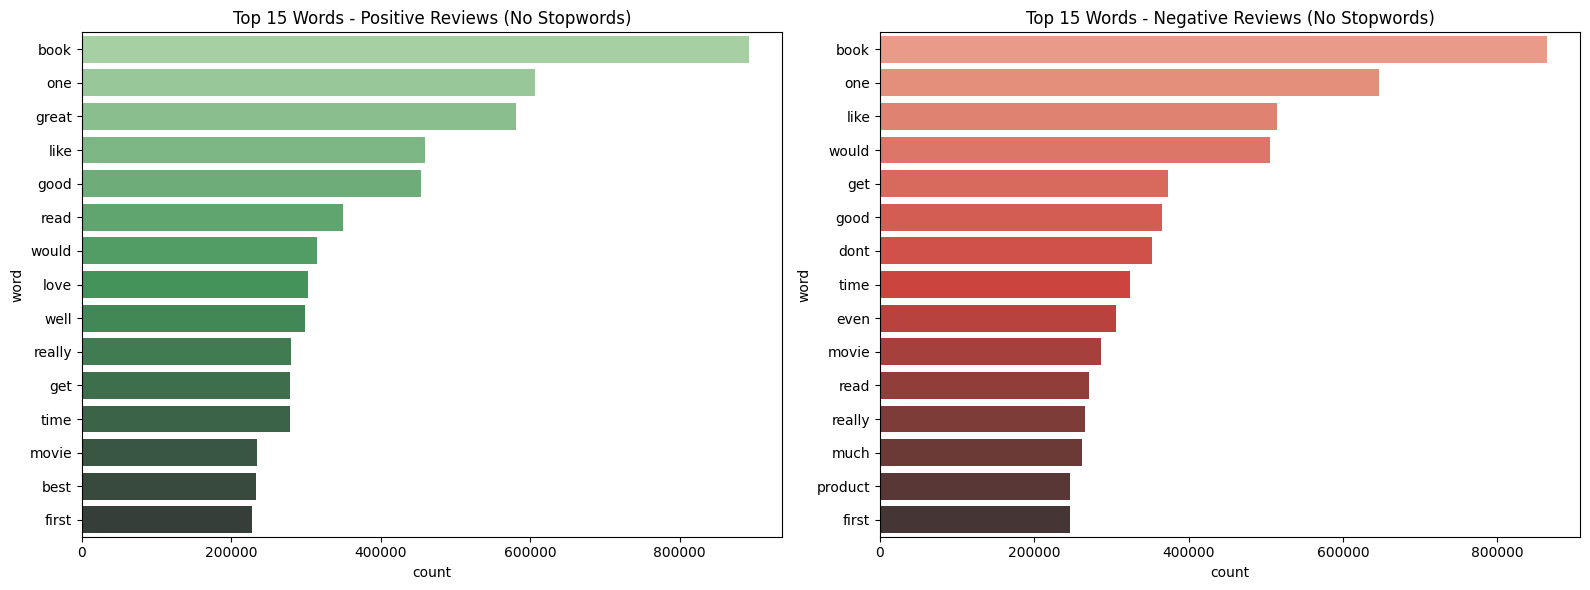

In [9]:
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def tokenize_and_filter(text_series):
    # Join all text into one string
    all_text = " ".join(text_series).lower()
    # Remove punctuation
    all_text = re.sub(r"[^\w\s]", "", all_text)
    # Tokenize
    tokens = all_text.split()
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Tokenize and filter stopwords
positive_tokens = tokenize_and_filter(df_filtered[df_filtered["label"] == 1]["content"])
negative_tokens = tokenize_and_filter(df_filtered[df_filtered["label"] == 0]["content"])

# Count top words
top_pos = Counter(positive_tokens).most_common(15)
top_neg = Counter(negative_tokens).most_common(15)

# Create DataFrames for plotting
df_top_pos = pd.DataFrame(top_pos, columns=["word", "count"])
df_top_neg = pd.DataFrame(top_neg, columns=["word", "count"])

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(data=df_top_pos, y="word", x="count", ax=ax[0], palette="Greens_d", hue="word", legend=False)
ax[0].set_title("Top 15 Words - Positive Reviews (No Stopwords)")
sns.barplot(data=df_top_neg, y="word", x="count", ax=ax[1], palette="Reds_d", hue="word", legend=False)
ax[1].set_title("Top 15 Words - Negative Reviews (No Stopwords)")
plt.tight_layout()
plt.show()

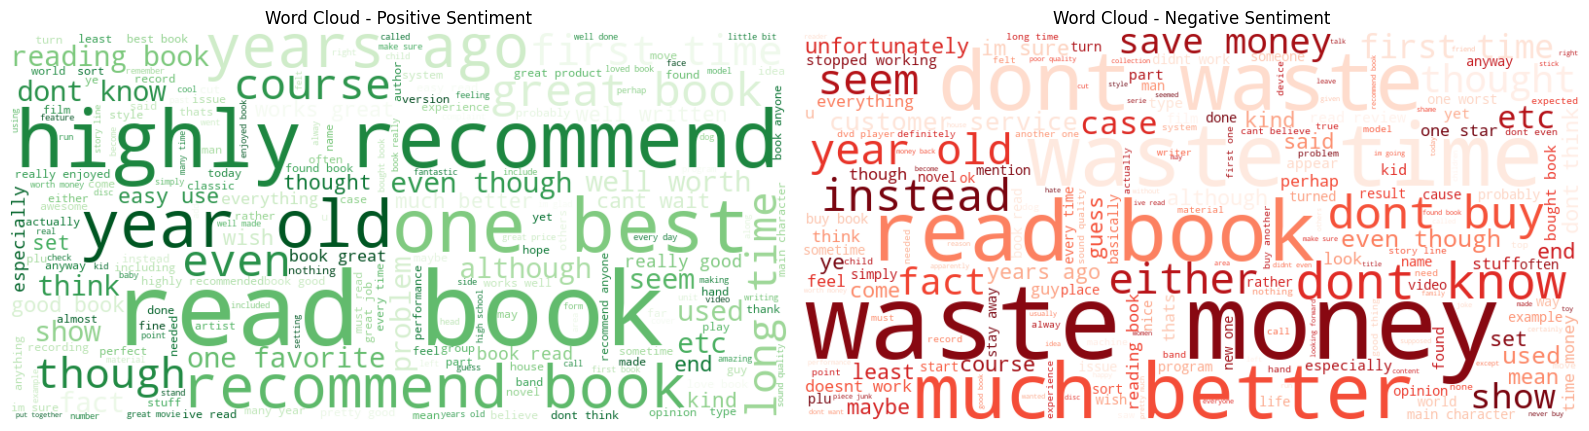

In [10]:
from wordcloud import WordCloud

# Generate text
pos_text = " ".join(positive_tokens)
neg_text = " ".join(negative_tokens)

# Generate word clouds
pos_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(pos_text)
neg_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(neg_text)

# Plot
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Sentiment")

plt.subplot(1, 2, 2)
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Sentiment")
plt.tight_layout()
plt.show()